In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import plotly.express as px


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('../data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [39]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))
#common_samples


Number of common samples: 864


In [4]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [107]:
#rnaseq_df_common.head()

In [5]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


In [6]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status'] = ['HRD' if x >= 42 else 'HR' for x in metadata['HRD-sum']]
#metadata[metadata['event.BRCA1'] == '1']

(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


In [7]:
# drop rna samples not in metadata
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samp = set(rnaseq_df['Case ID'])
metadata_samp = set(metadata.index)

# Find the intersection of all sample IDs
common_samp = rnaseq_samp.intersection(metadata_samp)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samp))



Number of common samples: 857


In [8]:
# Drop samples that are not common between metadata and rnaseq data
rnaseq_df_filtered = rnaseq_df_common[rnaseq_df_common['Case ID'].isin(common_samp)]
rnaseq_df_filtered.shape
#print(metadata.shape)

(921, 60663)

In [112]:
#rnaseq_df_filtered.head()


In [9]:

rnaseq_df_filtered = rnaseq_df_filtered.set_index('Case ID').drop(['Sample ID', 'Sample Type'], axis=1)


In [10]:
rnaseq_df_filtered = rnaseq_df_filtered.round().astype(int)
rnaseq_df_filtered = rnaseq_df_filtered[~rnaseq_df_filtered.index.duplicated(keep='first')]

In [11]:
print(f"Shape of rnaseq_df_filtered: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata: {metadata.shape}")

Shape of rnaseq_df_filtered: (857, 60660)
Shape of metadata: (857, 38)


In [12]:
print("rnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])  # Print first 5 index values
print("\nmetadata index:")
print(metadata.index[:5])  # Print first 5 index values

# Check for any mismatches
mismatched = set(rnaseq_df_filtered.index) ^ set(metadata.index)
print(f"\nNumber of mismatched indices: {len(mismatched)}")
if len(mismatched) > 0:
    print("Sample of mismatched indices:")
    print(list(mismatched)[:5])  # Print up to 5 mismatched indices


rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object', name='Case ID')

metadata index:
Index(['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF',
       'TCGA-A1-A0SG'],
      dtype='object', name='sample')

Number of mismatched indices: 0


In [13]:
#filtering metadata for nan Pam50 subtypes
metadata_dropna = metadata[~metadata['event.PAM50'].isna()]
metadata_dropna['event.PAM50'].unique()

array(['LumA', 'LumB', 'Basal', 'Her2'], dtype=object)

In [14]:
# Find common indices
common_indices = rnaseq_df_filtered.index.intersection(metadata_dropna.index)

# Filter both DataFrames to keep only common indices
rnaseq_df_filtered = rnaseq_df_filtered.loc[common_indices]
metadata_dropna = metadata_dropna.loc[common_indices]

# Verify the shapes and indices again
print(f"Shape of rnaseq_df_filtered after alignment: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata after alignment: {metadata_dropna.shape}")

print("\nrnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])
print("\nmetadata index:")
print(metadata_dropna.index[:5])

Shape of rnaseq_df_filtered after alignment: (843, 60660)
Shape of metadata after alignment: (843, 38)

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')

metadata index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')


In [15]:
#metadata_dropna[['HRD_status','event.PAM50']]
#rnaseq_df_filtered

In [28]:
HRP_meta = metadata_dropna[metadata_dropna['HRD-sum'] < 42]
HRD_meta = metadata_dropna[metadata_dropna['HRD-sum'] > 42]
HRD_meta.index

Index(['TCGA-E9-A1RH', 'TCGA-BH-A0HY', 'TCGA-AN-A04D', 'TCGA-E9-A2JS',
       'TCGA-E2-A150', 'TCGA-C8-A1HM', 'TCGA-A8-A08L', 'TCGA-E2-A14P',
       'TCGA-AN-A04A', 'TCGA-C8-A12P',
       ...
       'TCGA-D8-A13Y', 'TCGA-E9-A243', 'TCGA-E2-A1LH', 'TCGA-D8-A1JB',
       'TCGA-AR-A1AH', 'TCGA-A2-A0YJ', 'TCGA-GM-A2DH', 'TCGA-A2-A0T0',
       'TCGA-OL-A66I', 'TCGA-A8-A09M'],
      dtype='object', length=195)

In [30]:
# Get the intersection of indices between HRP_meta and rnaseq_df_filtered
shared_samples_HRP = HRP_meta.index.intersection(rnaseq_df_filtered.index)
shared_samples_HRD = HRD_meta.index.intersection(rnaseq_df_filtered.index)

# Filter rnaseq_df_filtered to include only the shared samples
HRP_rna = rnaseq_df_filtered.loc[shared_samples_HRP]
HRD_rna = rnaseq_df_filtered.loc[shared_samples_HRD]


In [56]:
# ['0', 'Bi-allelic-inactivation', 'Mono-allelic-inactivation']
#metadata_dropna[metadata_dropna['event.BRCA2'] == 'Mono-allelic-inactivation']
#metadata_dropna['event.BRCA2'].unique()

In [57]:
# ['0', 'Epigenetic-silencing', 'Bi-allelic-inactivation']
#metadata_dropna[metadata_dropna['event.BRCA1'] == 'Bi-allelic-inactivation']

In [34]:
def runDESeq2(counts, metadata, design_factors):
    # Step 2: Create the DESeqDataSet object
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
    )

    # Step 3: Run the differential expression analysis
    dds.deseq2()


    # Step 4: Get the results
    # stat_res = DeseqStats(dds)
    # stat_res.summary()

    # Get results table
    #results = stat_res.results_df
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    # Display the top differentially expressed genes
    #print(results.sort_values('padj').head(10))

    return results


## Runing DESeq2 on expression data based on the BRCA1 event for contrast

In [58]:
BRCA1_dds_contrast = runDESeq2(rnaseq_df_filtered, metadata_dropna, 'event.BRCA1')

Fitting size factors...
... done in 1.54 seconds.

Fitting dispersions...
... done in 18.23 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 21.09 seconds.

Fitting LFCs...
... done in 15.47 seconds.

Calculating cook's distance...
... done in 9.49 seconds.

Replacing 5933 outlier genes.

Fitting dispersions...
... done in 2.16 seconds.

Fitting MAP dispersions...
... done in 2.02 seconds.

Fitting LFCs...
... done in 1.96 seconds.

Running Wald tests...
... done in 2.59 seconds.



Log2 fold change & Wald test p-value: event.BRCA1 Bi-allelic-inactivation vs 0
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3205.150166        0.451717  0.196932  2.293772  0.021804   
TNMD          55.031984       -2.168191  0.483996 -4.479767  0.000007   
DPM1        2506.846125        0.047175  0.120467  0.391596  0.695357   
SCYL3       1669.317419       -0.484071  0.112930 -4.286486  0.000018   
C1orf112     761.472956        0.444980  0.154089  2.887820  0.003879   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.139249        0.217791  1.392181  0.156439  0.875687   
AL592295.6   448.806437       -0.367760  0.139697 -2.632553  0.008475   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     8.110358        0.035378  0.199591  0.177253  0.859309   
AP006621.6    34.086150       -0.337380  0.223442 -1.509923  0.131063   

                padj  
TSPAN6      0.056977 

In [67]:
BRCA1_dds_contrast.reset_index(inplace=True)

In [91]:
BRCA1_sig = BRCA1_dds_contrast[BRCA1_dds_contrast['pvalue'] < 0.01]

## Runing DESeq2 on expression data based on the BRCA2 event for contrast

In [96]:
BRCA2_dds_contrast = runDESeq2(rnaseq_df_filtered, metadata_dropna, 'event.BRCA2')
BRCA2_dds_contrast.reset_index(inplace=True)
BRCA2_sig = BRCA2_dds_contrast[BRCA2_dds_contrast['pvalue'] < 0.01]

Fitting size factors...
... done in 1.52 seconds.

Fitting dispersions...
... done in 21.10 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 23.70 seconds.

Fitting LFCs...
... done in 17.84 seconds.

Calculating cook's distance...
... done in 9.08 seconds.

Replacing 6383 outlier genes.

Fitting dispersions...
... done in 2.44 seconds.

Fitting MAP dispersions...
... done in 2.22 seconds.

Fitting LFCs...
... done in 2.28 seconds.

Running Wald tests...
... done in 2.83 seconds.



Log2 fold change & Wald test p-value: event.BRCA2 Bi-allelic-inactivation vs 0
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3205.150166        0.192261  0.214000  0.898416  0.368964   
TNMD          56.026144       -2.584290  0.532924 -4.849262       NaN   
DPM1        2506.846125        0.228469  0.130891  1.745486  0.080900   
SCYL3       1669.317419        0.128574  0.124569  1.032148  0.302003   
C1orf112     761.472956        0.141129  0.169088  0.834648  0.403916   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.139249       -0.272441  1.550260 -0.175739  0.860499   
AL592295.6   448.806437        0.014534  0.151936  0.095656  0.923793   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     8.110358       -0.220478  0.220780 -0.998632  0.317973   
AP006621.6    34.086150       -0.662178  0.243321 -2.721416  0.006500   

                padj  
TSPAN6      0.652153 

In [101]:
'RAD51C' in BRCA2_sig['index'].values

True

In [104]:
BRCA2_sig.to_csv('../data/BRCA2_deseq_genes.csv')
BRCA1_sig.to_csv('../data/BRCA1_deseq_genes.csv')

# testing DESEQ2

In [16]:

# Step 2: Create the DESeqDataSet object
dds = DeseqDataSet(
    counts=rnaseq_df_filtered,
    metadata=metadata_dropna,
    design_factors=["HRD_status"],
)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_9105/2970829575.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [17]:

# Step 3: Run the differential expression analysis
dds.deseq2()


Fitting size factors...
... done in 1.50 seconds.

Fitting dispersions...
... done in 18.12 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 22.10 seconds.

Fitting LFCs...
... done in 13.70 seconds.

Calculating cook's distance...
... done in 6.70 seconds.

Replacing 7635 outlier genes.

Fitting dispersions...
... done in 2.67 seconds.

Fitting MAP dispersions...
... done in 2.61 seconds.

Fitting LFCs...
... done in 2.31 seconds.



In [18]:

# Step 4: Get the results
# stat_res = DeseqStats(dds)
# stat_res.summary()

# Get results table
#results = stat_res.results_df
stats = DeseqStats(dds, contrast=["HRD-status", "HRD", "HR"])
stats.summary()
results = stats.results_df
# Display the top differentially expressed genes
#print(results.sort_values('padj').head(10))

results


Running Wald tests...
... done in 2.77 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6      3205.150166        0.113436  0.079847  1.420668  1.554134e-01   
TNMD          50.856466       -0.690929  0.192206 -3.594735  3.247225e-04   
DPM1        2506.846125        0.390477  0.047074  8.294998  1.085872e-16   
SCYL3       1669.317419       -0.288433  0.045554 -6.331630  2.425844e-10   
C1orf112     761.472956        0.552774  0.060263  9.172727  4.612028e-20   
...                 ...             ...       ...       ...           ...   
AC008763.4     0.139249        0.117514  0.564605  0.208135  8.351238e-01   
AL592295.6   448.806437       -0.044777  0.056731 -0.789286  4.299451e-01   
AC006486.3     0.000000             NaN       NaN       NaN           NaN   
AL391628.1     8.110358       -0.043118  0.081161 -0.531260  5.952389e-01   
AP006621.6    34.086150       -0.271339  0.089822 -3.020861  2.520568e-03   

                

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,3205.150166,0.113436,0.079847,1.420668,1.554134e-01,2.272388e-01
TNMD,50.856466,-0.690929,0.192206,-3.594735,3.247225e-04,8.838586e-04
DPM1,2506.846125,0.390477,0.047074,8.294998,1.085872e-16,1.357887e-15
SCYL3,1669.317419,-0.288433,0.045554,-6.331630,2.425844e-10,1.510050e-09
C1orf112,761.472956,0.552774,0.060263,9.172727,4.612028e-20,8.172645e-19
...,...,...,...,...,...,...
AC008763.4,0.139249,0.117514,0.564605,0.208135,8.351238e-01,NaN
AL592295.6,448.806437,-0.044777,0.056731,-0.789286,4.299451e-01,5.293022e-01
AC006486.3,0.000000,NaN,NaN,NaN,NaN,NaN
AL391628.1,8.110358,-0.043118,0.081161,-0.531260,5.952389e-01,6.828997e-01


# running DESEQ contrast on cancer subtypes

In [19]:
pam50_dict = {}
for pam50_subtype in metadata_dropna['event.PAM50'].unique():
    # Filter metadata for HRD and HR within each PAM50 subtype
    hrd_metadata = metadata_dropna[(metadata_dropna['HRD_status'] == 'HRD') & (metadata_dropna['event.PAM50'] == pam50_subtype)]
    hr_metadata = metadata_dropna[(metadata_dropna['HRD_status'] == 'HR') & (metadata_dropna['event.PAM50'] == pam50_subtype)]

    # Concatenate HRD and HR data for the subtype
    combined_metadata = pd.concat([hrd_metadata, hr_metadata])

    # print(combined_metadata)
    # break
    # Filter count data for samples in combined metadata
    #combined_counts = rnaseq_df_filtered[combined_metadata.index]


    # Find common indices
    common_indices = rnaseq_df_filtered.index.intersection(combined_metadata.index)

    # print(common_indices)
    # break
    # Filter both DataFrames to keep only common indices
    combined_counts = rnaseq_df_filtered.loc[common_indices]
    combined_metadata_common = combined_metadata.loc[common_indices]

    # print(combined_metadata_common['HRD_status'])
    
    # break

    # Create DESeq2 dataset
    dds = DeseqDataSet(counts=combined_counts, 
                       metadata=combined_metadata_common, 
                       design_factors=["HRD_status"], 
                      )

    # Run DESeq2
    dds.deseq2()

    # print("Design matrix columns:", dds.obsm['design_matrix'].columns)
    # break

    # Get results for HRD vs HR comparison within this subtype
    results = DeseqStats(dds, contrast=["HRD-status", "HRD", "HR"])
    results.summary()
    results_df = results.results_df

    # Filter for significantly differentially expressed genes (p-adj < 0.05)
    pam50_dict[pam50_subtype] = results_df[results_df['pvalue'] < 0.05]
    #common_genes[pam50_subtype] = set(significant_genes)

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_23238/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.16 seconds.

Fitting dispersions...
... done in 8.29 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 10.68 seconds.

Fitting LFCs...
... done in 6.36 seconds.

Calculating cook's distance...
... done in 0.30 seconds.

Replacing 5022 outlier genes.

Fitting dispersions...
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 0.90 seconds.

Fitting LFCs...
... done in 0.66 seconds.

Running Wald tests...
... done in 2.04 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3126.284146        0.121993  0.231881  0.526102  0.598817   
TNMD          15.801154       -0.133851  0.559972 -0.239032  0.811081   
DPM1        2884.821185        0.073083  0.163656  0.446567  0.655188   
SCYL3       1642.064358       -0.180789  0.171060 -1.056874  0.290569   
C1orf112     698.961023        0.232868  0.181696  1.281633  0.199971   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.055004       -0.007614  2.673335 -0.002848  0.997727   
AL592295.6   400.618018       -0.197163  0.230876 -0.853978  0.393117   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     6.245845        0.205582  0.271663  0.756754  0.449197   
AP006621.6    63.675952       -1.237753  0.370542 -3.340382  0.000837   

                padj  
TSPAN6      0.888739  
TNMD        0.9601

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_23238/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.29 seconds.

Fitting dispersions...
... done in 11.81 seconds.

Fitting dispersion trend curve...
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 13.87 seconds.

Fitting LFCs...
... done in 8.61 seconds.

Calculating cook's distance...
... done in 0.95 seconds.

Replacing 6064 outlier genes.

Fitting dispersions...
... done in 1.71 seconds.

Fitting MAP dispersions...
... done in 2.00 seconds.

Fitting LFCs...
... done in 1.37 seconds.

Running Wald tests...
... done in 2.31 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      2441.419886       -0.113535  0.158897 -0.714520  0.474906   
TNMD          37.285179       -0.955327  0.392469 -2.434145  0.014927   
DPM1        3082.254862        0.238984  0.101162  2.362397  0.018157   
SCYL3       1751.057907       -0.191229  0.088167 -2.168945  0.030087   
C1orf112     891.084929        0.256668  0.119877  2.141090  0.032267   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.146647        0.243259  1.012640  0.240222  0.810158   
AL592295.6   536.873905       -0.271756  0.107588 -2.525885  0.011541   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     7.923991        0.011701  0.165835  0.070560  0.943748   
AP006621.6    25.906255       -0.243882  0.154611 -1.577385  0.114707   

                padj  
TSPAN6      0.749308  
TNMD        0.1237

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_23238/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.71 seconds.

Fitting dispersions...
... done in 16.01 seconds.

Fitting dispersion trend curve...
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 19.26 seconds.

Fitting LFCs...
... done in 11.96 seconds.

Calculating cook's distance...
... done in 2.97 seconds.

Replacing 5105 outlier genes.

Fitting dispersions...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 1.91 seconds.

Fitting LFCs...
... done in 1.67 seconds.

Running Wald tests...
... done in 2.52 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3134.482009       -0.547427  0.201575 -2.715752  0.006613   
TNMD          58.669703       -0.938723  0.436366 -2.151227  0.031458   
DPM1        2053.125178        0.481499  0.099724  4.828304  0.000001   
SCYL3       1765.960425       -0.058344  0.107166 -0.544427  0.586148   
C1orf112     577.884821        0.066428  0.123506  0.537849  0.590681   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.133167       -0.071869  1.509291 -0.047617  0.962021   
AL592295.6   432.652328        0.388975  0.134980  2.881736  0.003955   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     8.569988       -0.032803  0.195565 -0.167736  0.866791   
AP006621.6    30.259944       -0.762389  0.191186 -3.987687  0.000067   

                padj  
TSPAN6      0.047581  
TNMD        0.1324

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_23238/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.81 seconds.

Fitting dispersions...
... done in 10.67 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 13.67 seconds.

Fitting LFCs...
... done in 7.38 seconds.

Calculating cook's distance...
... done in 0.61 seconds.

Replacing 5852 outlier genes.

Fitting dispersions...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 1.40 seconds.

Fitting LFCs...
... done in 0.99 seconds.

Running Wald tests...
... done in 2.21 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      4328.605474       -0.076081  0.128895 -0.590256  0.555019   
TNMD          32.019940        1.100118  0.430135  2.557612  0.010539   
DPM1        2877.493819        0.008037  0.093179  0.086248  0.931269   
SCYL3       1273.178538       -0.146394  0.103343 -1.416577  0.156607   
C1orf112    1157.423733       -0.061664  0.137426 -0.448705  0.653645   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.188032        0.136116  1.304933  0.104309  0.916924   
AL592295.6   407.122125       -0.053390  0.120584 -0.442759  0.657940   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     7.803711        0.042903  0.190036  0.225763  0.821386   
AP006621.6    38.496432       -0.443538  0.192311 -2.306364  0.021090   

                padj  
TSPAN6      0.851343  
TNMD        0.1740

In [20]:
pam50_dict.keys()

dict_keys(['Her2', 'LumB', 'LumA', 'Basal'])

In [21]:
Her2_genes = set(pam50_dict['Her2'].index)
LumB_genes = set(pam50_dict['LumB'].index)
LumA_genes = set(pam50_dict['LumA'].index)
Basal_genes = set(pam50_dict['Basal'].index)

shared_de_genes = Her2_genes.intersection(LumA_genes).intersection(LumB_genes).intersection(Basal_genes)

In [22]:
len(shared_de_genes)

84

In [ ]:
print(shared_de_genes)

{'ZDHHC22', 'CSAG3', 'CD177', 'GP2', 'IGFALS', 'GACAT2', 'TFF3', 'NXNL2', 'FAM174A', 'CRACR2B', 'HEPACAM2', 'HTATSF1', 'CACNA1B', 'ALMS1-IT1', 'ATRIP', 'LMNTD2', 'PLOD2', 'ABHD17AP4', 'FGB', 'ZG16B', 'LINC02864', 'DBF4B', 'MTND1P23', 'CSAG2', 'SCGB2A1', 'LMOD3', 'INSM1', 'CCL20', 'CCDC144NL-AS1', 'CACNA1F', 'LRRC59', 'RGS22', 'CSAG1', 'FAR2P3', 'TAF3', 'SMOC2', 'NAIPP2', 'CPB1', 'AL049839.2', 'FOXA3', 'PI3', 'LINC01238', 'IGSF22', 'CENPA', 'CYB561D2', 'AC027228.2', 'PHB', 'SLC25A46', 'MUC5AC', 'IQCH-AS1', 'PARP2', 'DSCAM', 'AC009262.1', 'CHGB', 'FXYD4', 'PNLDC1', 'BTF3', 'VWA5A', 'AC114550.1', 'IFITM5', 'ACTL6A', 'BET1L', 'LEP', 'AL591845.1', 'MAGEA12', 'CADPS', 'ROBO2', 'CHRNA5', 'C8orf34-AS1', 'KLK3', 'PEX11B', 'SHC2', 'AC100810.1', 'CALML3-AS1', 'LRRC46', 'PPP2R2A', 'AL354726.1', 'PLA2G2C', 'CREB3L4', 'LTC4S', 'C8orf34', 'PTCD2', 'AL160191.3', 'IFT74'}


: 

# Leo graphs stuff

In [127]:
# Flatten the data and mark genes that meet the filtering criteria
plot_data = []
for subtype, df in pam50_dict.items():
    df = df.copy()
    df['Gene'] = df.index  # Ensure gene names are in a column for easier handling
    df['Subtype'] = subtype
    df['-log10(pvalue)'] = -np.log10(df['pvalue'])  # Transform p-value for visualization
    # Mark genes that meet the criteria
    df['Highlight'] = df.apply(lambda row: (
        row['Gene'] in shared_de_genes and 
        row['-log10(pvalue)'] > 1.30 and 
        (row['log2FoldChange'] < -1 or row['log2FoldChange'] > 1)
    ), axis=1)
    plot_data.append(df)

# Combine all subtypes into a single DataFrame for Plotly
plot_data_combined = pd.concat(plot_data)

# Create the scatter plot
fig = px.scatter(
    plot_data_combined,
    x='log2FoldChange',
    y='-log10(pvalue)',
    color='Highlight',  # Color only the genes meeting the criteria
    
    hover_data=['Gene', 'Subtype'],
    title="Significantly upregulated or downregulated genes shared among all subtypes",
    labels={"log2FoldChange": "Log2 Fold Change", "-log10(pvalue)": "-Log10(p-value)"}

)

# Add dotted lines
fig.add_shape(
    type="line",
    x0=-1, y0=0, x1=-1, y1=plot_data_combined['-log10(pvalue)'].max(),
    line=dict(color="black", width=1, dash="dot")
)
fig.add_shape(
    type="line",
    x0=1, y0=0, x1=1, y1=plot_data_combined['-log10(pvalue)'].max(),
    line=dict(color="black", width=1, dash="dot")
)
fig.add_shape(
    type="line",
    x0=plot_data_combined['log2FoldChange'].min(), y0=1.30, x1=plot_data_combined['log2FoldChange'].max(), y1=1.30,
    line=dict(color="black", width=1, dash="dot")
)

# Customize layout for better visualization
fig.update_layout(
    legend_title_text="Gene Highlight",
    legend=dict(x=1, y=1, title={'text': 'Common gene among all subtype'})
)

In [132]:
#results_df

In [133]:
# 1. Separate upregulated and downregulated genes
upregulated = results_df[results_df['log2FoldChange'] > 0]
downregulated = results_df[results_df['log2FoldChange'] < 0]

# 2. Sort each by p-value
upregulated_sorted = upregulated.sort_values(by='padj')
downregulated_sorted = downregulated.sort_values(by='padj')

# 3. Calculate the number of genes to select (top 2%)
top_n_upregulated = int(len(upregulated_sorted) * 0.05) or 1  # Ensure at least one gene is selected
top_n_downregulated = int(len(downregulated_sorted) * 0.05) or 1

# 4. Select the top 2% based on p-value
top_upregulated = upregulated_sorted.head(top_n_upregulated)
top_downregulated = downregulated_sorted.head(top_n_downregulated)

# Combine the results
top_genes = pd.concat([top_upregulated, top_downregulated])
top_genes


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
RPL26P30,251.617677,4.194152,0.396517,10.577486,3.789920e-26,1.296986e-21
ACTA1,623.529667,3.137186,0.426622,7.353543,1.930206e-13,3.302775e-09
RANBP20P,81.395436,3.231968,0.461721,6.999825,2.562827e-12,2.923503e-08
AC015660.1,116.712445,2.175907,0.324707,6.701142,2.067968e-11,1.769250e-07
EZHIP,31.197406,4.462987,0.671852,6.642811,3.077557e-11,2.106403e-07
...,...,...,...,...,...,...
AL353138.1,3.030020,-0.786613,0.357750,-2.198779,2.789367e-02,2.728994e-01
IGSF23,50.616639,-0.788911,0.358822,-2.198612,2.790554e-02,2.729244e-01
IGLL1,8.694877,-0.957098,0.435387,-2.198267,2.793009e-02,2.730144e-01
P2RY2,470.179433,-0.629124,0.286242,-2.197875,2.795803e-02,2.732095e-01


In [134]:
top_genes.to_csv('/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/top_deseq_genes.tsv',sep='\t', index = True)

In [136]:
# Sort the DataFrame by padj values
results_sorted = results_df.sort_values('padj', ascending=True)

num_rows_to_keep = int(len(results_df) * 0.02)

bottom_2_percent = results_sorted.head(num_rows_to_keep)
print(bottom_2_percent.shape)
bottom_2_percent.head()
bottom_2_percent.to_csv('/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/bottom_2_percent.tsv', sep='\t', index = True)

(1213, 6)


In [137]:
bottom_2_percent.reset_index(inplace=True)

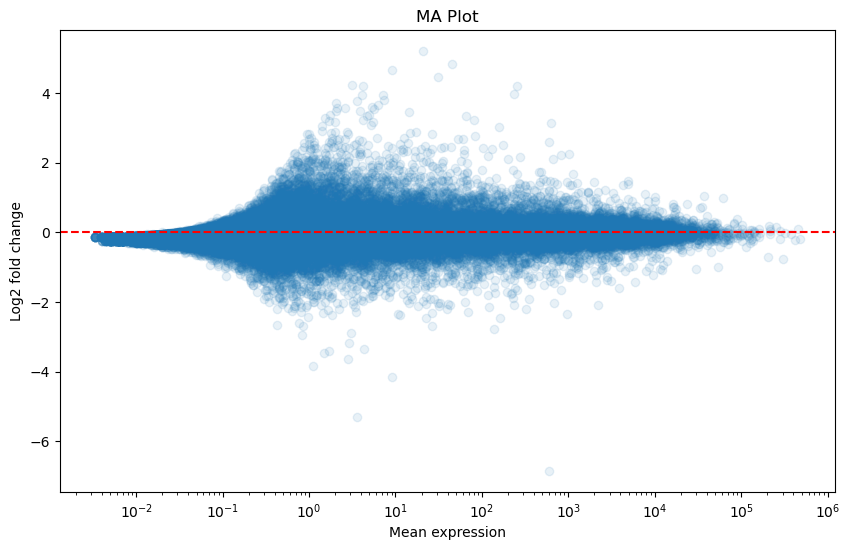

In [139]:

# Step 5: Visualize the results

# MA plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['baseMean'], results_df['log2FoldChange'], alpha=0.1)
plt.xscale('log')
plt.xlabel('Mean expression')
plt.ylabel('Log2 fold change')
plt.title('MA Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


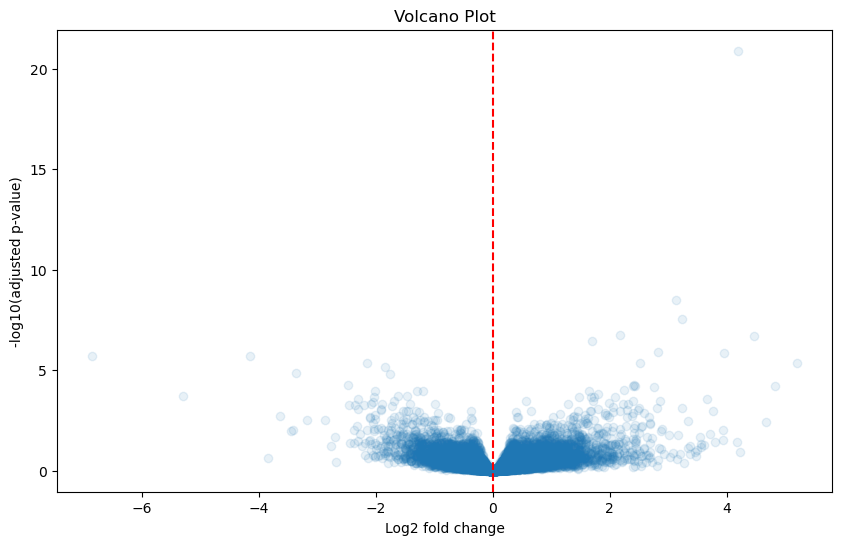

In [140]:

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['log2FoldChange'], -np.log10(results_df['padj']), alpha=0.1)
plt.xlabel('Log2 fold change')
plt.ylabel('-log10(adjusted p-value)')
plt.title('Volcano Plot')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


### Running decouplR on Top genes from Deseq

In [141]:
msigdb = dc.get_resource('MSigDB')
msigdb.drop_duplicates(inplace=True)

In [142]:
bottom_2_percent

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,RPL26P30,251.617677,4.194152,0.396517,10.577486,3.789920e-26,1.296986e-21
1,ACTA1,623.529667,3.137186,0.426622,7.353543,1.930206e-13,3.302775e-09
2,RANBP20P,81.395436,3.231968,0.461721,6.999825,2.562827e-12,2.923503e-08
3,AC015660.1,116.712445,2.175907,0.324707,6.701142,2.067968e-11,1.769250e-07
4,EZHIP,31.197406,4.462987,0.671852,6.642811,3.077557e-11,2.106403e-07
...,...,...,...,...,...,...,...
1208,THOC5,2658.727999,0.307639,0.105131,2.926238,3.430883e-03,9.713191e-02
1209,AC025839.1,1.363739,-2.086778,0.713305,-2.925504,3.438986e-03,9.726361e-02
1210,AC068790.5,6.006298,0.624464,0.213536,2.924389,3.451330e-03,9.740351e-02
1211,H2AC11,241.470349,0.705541,0.241270,2.924286,3.452471e-03,9.740351e-02


In [151]:
deseq_genes = bottom_2_percent['index']
gene_list = deseq_genes.to_list()

In [152]:
gene_list

['RPL26P30',
 'ACTA1',
 'RANBP20P',
 'AC015660.1',
 'EZHIP',
 'TEX14',
 'AL513318.1',
 'CSAG1',
 'SMR3B',
 'ZP2',
 'DHRS2',
 'AQP4',
 'PAGE2',
 'AL137025.1',
 'LINC02617',
 'LINC00158',
 'MUC6',
 'GRIA2',
 'FAM133A',
 'LINC00923',
 'MAGEA10',
 'KRT13',
 'AC079949.2',
 'SP6',
 'NRG1',
 'GJA3',
 'RASL11A',
 'TSPEAR-AS2',
 'AL355596.2',
 'MTUS2',
 'SEZ6',
 'SH2D5',
 'CXCL1',
 'MTCO1P53',
 'CHRDL2',
 'AL391832.2',
 'NXPH1',
 'IGKV1-33',
 'LGSN',
 'PDIA2',
 'PAX1',
 'LYSMD4',
 'GFRA3',
 'HOXB-AS3',
 'GDPD2',
 'IGHV2-5',
 'AL356215.1',
 'LGR4',
 'ALPL',
 'GSTA1',
 'TRDN',
 'GRIK3',
 'ADCYAP1',
 'PAX2',
 'TFAP2B',
 'IGSF9B',
 'LINC02577',
 'CSAG2',
 'AC079460.2',
 'AC008443.2',
 'ADGRL3',
 'NTSR2',
 'KCNK9',
 'ZNF560',
 'ANGPTL7',
 'GPC5',
 'ACAN',
 'GPX2',
 'HOXB5',
 'LINC02405',
 'GTSF1',
 'H2AZ2P1',
 'Z97653.1',
 'PHEX',
 'TRIM67',
 'TBR1',
 'QARS1',
 'PTCHD4',
 'MESD',
 'MUC13',
 'NCAN',
 'LINC02055',
 'PIPOX',
 'RN7SL170P',
 'FRMD3',
 'LINC01579',
 'TPPP2',
 'PENK',
 'ZFPM2-AS1',
 'SOX2'

In [153]:
ORA_df = dc.get_ora_df(
    df = gene_list,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

Running ora on df with 1213 targets for 33552 sources with 20000 background features.


In [154]:
ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
test_pval_filt.tail(10)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log 10 p-value
1102,DESCARTES_FETAL_HEART_SATB2_LRRC7_POSITIVE_CELLS,96,0.156250,6.434696e-04,1.000000e+00,2.667581,19.603081,BHLHE22;CALN1;CAMKV;CDH4;CSMD3;FABP7;GLRA2;MIR...,3.191472
17600,MIKKELSEN_MEF_HCP_WITH_H3K27ME3,588,0.095238,5.530927e-04,1.000000e+00,1.610136,12.075993,ACAN;ACHE;ADCYAP1;ADGRB3;AJM1;ALOX15;B3GALT5;B...,3.257202
7544,GOMF_NEUROTROPHIN_BINDING,10,0.500000,1.586196e-04,4.728847e-01,8.664637,75.806927,A2M;FURIN;HAP1;NTRK3;PCSK6,3.799643
17595,MIKKELSEN_IPS_WITH_HCP_H3K27ME3,103,0.165049,1.465251e-04,4.728847e-01,2.811794,24.823400,ACHE;ADGRL3;ALOX15;ARX;CA10;HBQ1;HOXB5;HOXB8;H...,3.834088
23687,chr15q24,66,0.196970,1.416527e-04,4.728847e-01,3.370973,29.874011,CSPG4;EDC3;ETFA;FAM219B;FBXO22;NPTN;ODF3L1;PTP...,3.848775
19862,MODULE_220,333,0.114114,1.357354e-04,4.728847e-01,1.931485,17.199496,ANOS1;APBA1;AQP4;BMP1;CCN2;CDX1;CRABP2;CRMP1;C...,3.867307
23688,chr15q25,74,0.229730,1.545877e-06,9.217294e-03,3.912011,52.342394,ABHD17C;ADAMTSL3;BTBD1;CHRNA5;HYKK;MESD;MORF4L...,5.810825
20464,NIKOLSKY_BREAST_CANCER_15Q26_AMPLICON,22,0.545455,8.608064e-10,6.843411e-06,9.237758,192.821130,ASB7;IGF1R;LINS1;LRRC28;LYSMD4;MEF2A;PCSK6;SEL...,9.065095
23689,chr15q26,79,0.291139,1.513108e-10,1.804382e-06,4.946447,111.847503,ACAN;AEN;ASB7;BLM;CRTC3;FANCI;FURIN;IGF1R;LINS...,9.820130
23757,chr3p21,202,0.242574,2.869029e-17,6.842633e-13,4.155975,158.300991,ACTR8;ACY1;APEH;ARIH2;ARIH2OS;BSN;CACNA2D3;CAM...,16.542265


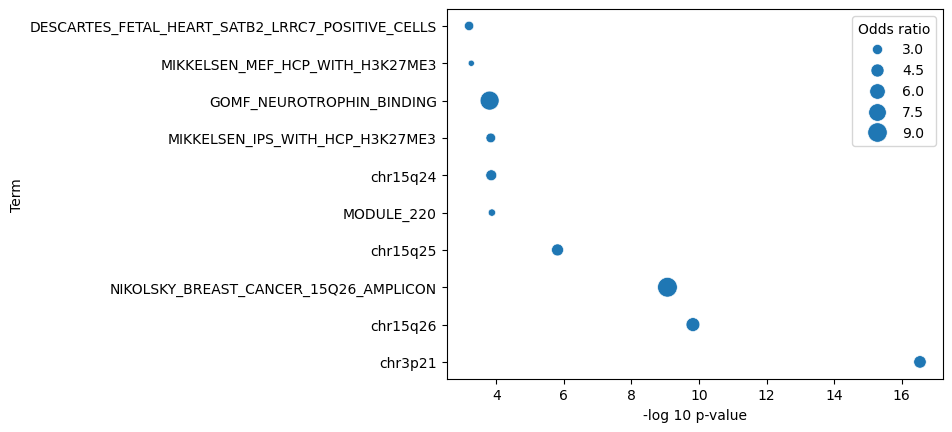

In [155]:
plot = sns.scatterplot(
    data=test_pval_filt.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)

Running ora on df with 84 targets for 33552 sources with 20000 background features.


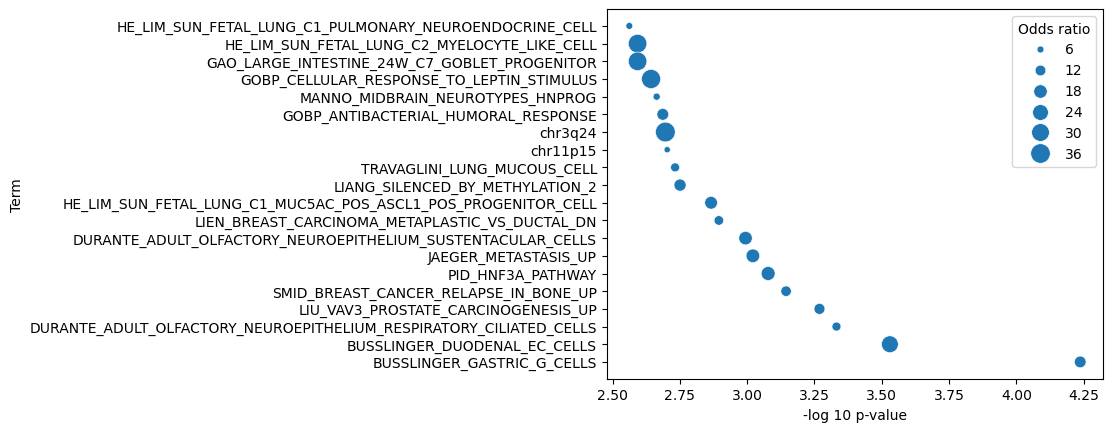

: 

In [156]:
ORA_df_shared = dc.get_ora_df(
    df = list(shared_de_genes),
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

ORA_df_shared['-log 10 p-value'] = np.log10(ORA_df_shared['p-value'])*-1
test_pval_filt = ORA_df_shared[ORA_df_shared['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])

#test_pval_filt.tail(10)

plot = sns.scatterplot(
    data=test_pval_filt.tail(20), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)